## Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.



<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`. 

a. Read in the dataset and take a look at the top few rows here:

In [3]:
#Import the dataset
df = pd.read_csv('ab_data.csv')
#Print the first 5 rows
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b.Find the number of rows in the dataset.

In [4]:
#Display data set rows number
df.shape[0]

294478

c. The number of unique users in the dataset.

In [5]:
#Dispaly The number of unique user  
df.user_id.nunique()

290584

d. The proportion of users converted.

In [6]:
#calculate proportion of users converted
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [7]:
#G1 when group is treatment but langing page is the old page
G1 = df.query('group == "treatment" and landing_page == "old_page"')
len(G1)

1965

In [8]:
#G2 when group is control but langing page is the new page
G2 = df.query('group == "control" and landing_page == "new_page"')
len(G2)

1928

In [9]:
#calculate the number of time new_page and treatment don't line up
len(G1) + len(G2)

3893

f. Do any of the rows have missing values?

In [10]:
#Display data info and ensure that there is no NULL values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.



In [11]:

df.drop(df.query("group == 'treatment' and landing_page == 'old_page'").index, inplace=True)

df.drop(df.query("group == 'control' and landing_page == 'new_page'").index, inplace=True)

In [12]:
# Double Check all of the correct rows were removed - this should be 0
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

0

In [13]:
# make a new data frame df2
df2 = df

`3.` Answer the following questions .

a. How many unique **user_id**s are in **df2**?

In [14]:
#Display the number of unique user_id 
len(df['user_id'].unique())

290584

b. There is one **user_id** repeated in **df**.  What is it?

In [15]:
# Check if There is user_id repeated in df2
df2.user_id[df2.user_id.duplicated()]

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [16]:
# The row information for the repeat user_id
df2.loc[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [17]:
# Now removing duplicate rows
df2 = df2.drop_duplicates()
# Check if there is any duplicate row 
sum(df2.duplicated())

0

`4.` Use **df2** in the cells below to answer the following questions

a. What is the probability of an individual converting regardless of the page they receive?

In [18]:
# Probability of an individual converting regardless of the page they receive
df2['converted'].mean()

0.11959667567149027

b. Given that an individual was in the `control` group, what is the probability they converted?

In [19]:
# The probability of an individual converting given that an individual was in the control group
control = len(df2.query('group=="control" and converted==1'))/len(df2.query('group=="control"'))
control

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [20]:
# The probability of an individual converting given that an individual was in the treatment group
treatment = len(df2.query('group=="treatment" and converted==1'))/len(df2.query('group=="treatment"'))
treatment

0.11880724790277405

d. What is the probability that an individual received the new page?

In [21]:
# The probability of individual received new page
len(df2.query('landing_page=="new_page"'))/len(df2.index)

0.5000636646764286

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**According to the analysis I see that there is no more conversion between new page and old page. As the converting rate is aproximately similar in both cases so it is important to analyze other factors.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**$H_{0}$ : $P_{new}$ <= $P_{old}$** 

**$H_{1}$ : $P_{new}$ > $P_{old}$** 

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [22]:
#We assume that there is no difference between the 
#conversion rates of old and new page. Thus, the whole dataset is used to 
#calculate the convertion rate for the new page (pnew).
p_new = df2['converted'].mean()
p_new

0.11959667567149027

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [23]:
#We assume that there is no difference between the 
#conversion rates of old and new page. Thus, the whole dataset is used to 
#calculate the convertion rate for the old_page (pold).
p_old = df2['converted'].mean()
p_old

0.11959667567149027

c. What is $n_{new}$, the number of individuals in the treatment group?

In [24]:
#calculate the number of users landed and new_page
n_new = len(df2.query('landing_page == "new_page"'))

n_new

145311

d. What is $n_{old}$, the number of individuals in the control group?

In [25]:
#calculate the number of users landed and new_page
n_old = len(df2.query('landing_page == "old_page"'))
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [26]:
## simulate n_new transactions with a convert rate of p_new under the null
new_page_converted = np.random.choice([0, 1], size=n_new, p=[(1 - p_new), p_new])
new_page_converted.mean()

0.11937843659461431

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [27]:
## simulate n_old transactions with a convert rate of p_new under the null
old_page_converted = np.random.choice([0, 1], size=n_old, p=[(1 - p_old), p_old])
old_page_converted.mean()


0.11913349945620001

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [28]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice([0, 1], size=n_new, p=[(1 - p_new), p_new])
    old_page_converted = np.random.choice([0, 1], size=n_old, p=[(1 - p_old), p_old])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())
    

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

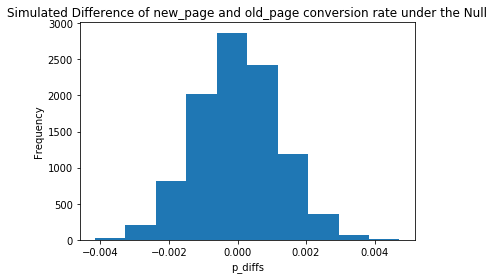

In [29]:
# convert to numpy array


# plot sampling distribution
plt.hist(p_diffs)
plt.xlabel('p_diffs')
plt.ylabel('Frequency')
plt.title('Simulated Difference of new_page and old_page conversion rate under the Null');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [30]:
df_control = df2.query('group == "control"')
df_treatment = df2.query('group == "treatment"')

# display observed difference
obs_diff = df_treatment.converted.mean() - df_control.converted.mean()
obs_diff

-0.0015790565976871451

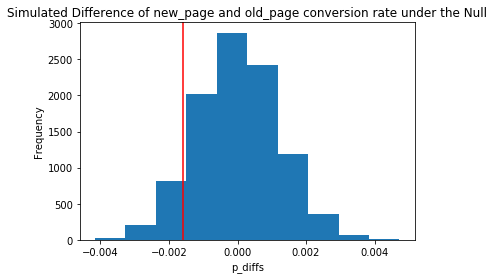

In [31]:
# plot line for observed statistic
plt.hist(p_diffs)
plt.xlabel('p_diffs')
plt.ylabel('Frequency')
plt.axvline(x=obs_diff, color='r', label="Observed difference")
plt.title('Simulated Difference of new_page and old_page conversion rate under the Null');

In [32]:
#calculate the proportion of p_diffs greater than the observe difference
(p_diffs > obs_diff).mean()

0.90790000000000004

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**91.34% is the proportion of the p_diffs that are greater than the actual difference observed in ab_data.csv. In scientific studies this value is also called p-value. This value means that we cannot reject the null hypothesis and that we do not have sufficient evidence that the new_page has a higher conversion rate than the old_page**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [33]:
import statsmodels.api as sm

convert_old = sum(df2.query("group == 'control'")['converted'])
convert_new = sum(df2.query("group == 'treatment'")['converted'])
n_old = len(df2.query("group == 'control'"))
n_new = len(df2.query("group == 'treatment'"))

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [34]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
z_score, p_value

(-1.3116075339133115, 0.90517370514059103)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Z score is -1.31 and it is less than the critical value 1.64. Also the p_value is 0.9 and is higher than 0.05 significance level.So this means we can not be confident with a 95% confidence level that the converted rate of the new_page is larger than the old_page.**


<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**We deal with a binary variable (converted vs not converted).So we need to use a logistic regression..**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [35]:
df2[['control','treatment']]= pd.get_dummies(df2['group'])
df2 = df2.drop('control',axis = 1)

df2.head()

,user_id,timestamp,group,landing_page,converted,treatment
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0


In [37]:
df3 = df2.rename(columns={'treatment': 'ab_page'})
df3.head()

,user_id,timestamp,group,landing_page,converted,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [39]:
from scipy import stats
stats.chisqprob = lambda chisq, df3: stats.chi2.sf(chisq, df3)

df3['intercept'] = 1

lm = sm.Logit(df3['converted'],df3[['intercept','ab_page']])
results = lm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [40]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290583
Method:                           MLE   Df Model:                            1
Date:                Tue, 13 Oct 2020   Pseudo R-squ.:               8.085e-06
Time:                        22:28:48   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1897
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.312      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**We have get a different ab_page P-value but still greater than 0.05, In Part2 was randomly choosed 10000 times and we use one side test in it so it was high 0.9, But in part3 we have used two side test.**


**In the two cases part2 and part3 we cannot neglect the NULL.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Consider other factors will lead to better decision making and get hypotheses test results more accurate
when we add many factors with working on regression maybe lead to a useless outcome, especially if the factors have no influences or only have little influence.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [41]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df3.set_index('user_id'), how='inner')

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [42]:
df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept
user_id,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,0,1
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1


In [43]:
df_new.country.unique()

array(['US', 'UK', 'CA'], dtype=object)

In [46]:
df_new['country'].value_counts()

US    203620
UK     72466
CA     14499
Name: country, dtype: int64

In [47]:
#mean of conversion rate
df_new.ab_page.mean()

0.5000636646764286

In [48]:
#mean conversion rate by country
df_new.groupby(['country'], as_index=False).mean()

,country,converted,ab_page,intercept
0,CA,0.115318,0.503552,1.0
1,UK,0.120594,0.498247,1.0
2,US,0.119546,0.500462,1.0


In [49]:
#mean conversion rate by landing_page 
df_new.groupby(['ab_page'], as_index=False).mean()

,ab_page,converted,intercept
0,0,0.120386,1.0
1,1,0.118807,1.0


In [50]:
# Create the necessary dummy variables
df_new[['CA','UK', 'US']]= pd.get_dummies(df_new['country'])

df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept,CA,UK,US
user_id,,,,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1,0,0,1
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1,0,0,1
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,0,1,0,0,1
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1,0,0,1
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1,0,0,1


In [51]:
### Fit Your Linear Model And Obtain the Results

df_new['intercept'] = 1

lm = sm.Logit(df_new['converted'],df_new[['intercept','ab_page','CA','US']])
results = lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            3
Date:                Tue, 13 Oct 2020   Pseudo R-squ.:               2.324e-05
Time:                        22:39:09   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1758
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9794      0.013   -155.414      0.000      -2.004      -1.954
ab_page       -0.0150      0.011     -1.308      0.191      -0.037       0.007
CA            -0.0506      0.028     -1.784      0.074      -0.106       0.005
US            -0.0099      0.013     -0.744      0.457      -0.036       0.016
==============================================================================
"""

**The country does not appear to have influence on the convertion rate. P-values for the two dummy country variables are above 0.05. Note the CA variable get closes to 0.05**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [52]:
#mean conversion rate by country and landing_page - 
#checking for possible interactions (whether the influence of landing_page
#is different for the countries)

df_new.groupby(['country','ab_page'], as_index=False).mean()

,country,ab_page,converted,intercept,CA,UK,US
0,CA,0,0.118783,1.0,1,0,0
1,CA,1,0.111902,1.0,1,0,0
2,UK,0,0.120022,1.0,0,1,0
3,UK,1,0.121171,1.0,0,1,0
4,US,0,0.120630,1.0,0,0,1
5,US,1,0.118464,1.0,0,0,1


In [53]:
df_new.head()
df_new['ab_US'] = df_new.US *df_new.ab_page
df_new['ab_CA'] = df_new.CA *df_new.ab_page

df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept,CA,UK,US,ab_US,ab_CA
user_id,,,,,,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1,0,0,1,1,0
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1,0,0,1,1,0
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,0,1,0,0,1,0,0
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1,0,0,1,1,0
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1,0,0,1,1,0


In [54]:
df_new['intercept'] = 1

lm = sm.Logit(df_new['converted'],df_new[['intercept','ab_page','US','ab_US','CA','ab_CA']])
results = lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366108
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290579
Method:                           MLE   Df Model:                            5
Date:                Tue, 13 Oct 2020   Pseudo R-squ.:               3.483e-05
Time:                        22:40:34   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1918
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9922      0.016   -123.457      0.000      -2.024      -1.961
ab_page        0.0108      0.023      0.475      0.635      -0.034       0.056
US             0.0057      0.019      0.306      0.760      -0.031       0.043
ab_US         -0.0314      0.027     -1.181      0.238      -0.084       0.021
CA            -0.0118      0.040     -0.296      0.767      -0.090       0.066
ab_CA         -0.0783      0.057     -1.378      0.168      -0.190       0.033
==============================================================================
"""

### Conclusion on regression ###
**The p_value for both interaction terms is higher than 0.05.
Thus, the influence of landing_page in the US is not different to the influence of landing_page in the other countries.
And the influence of landing_page in Canada is not different to the influence of landing_page in the other countries.**

### Final Conclusion ###

**In conclusion, there is not enough evidence that the new_page increases the conversion rate as compared to the old_page. This is based on the probability figures, A/B test and regression. There is no strong evidence that the countries (US, CA and UK) influence the conversion rate.
Since the sample size is large continuing the testing of the new_page is likely not necessary. It is best to focus on the development of another new landing page.**

In [181]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0